![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Nubes de palabras del 3er Informe de gobierno federal

##Ingeniería de Características 2021-2

**Julio Waissman**

septiembre, 2021


## Introducción

En esta libreta vamos a ver como hacer nubes de palabras como un pretexto para ver como usar la biblioteca `spacy` en la limpieza de lenguaje natural (procesamiento sencillo).


Como un ejemplo de aplicación actual (al momento de hacer la libreta, claro). Vamos a utilizar el [Discurso del presidente Andrés Manuel López Obrador durante el Tercer Informe de Gobierno](https://lopezobrador.org.mx/2021/09/01/discurso-del-presidente-andres-manuel-lopez-obrador-durante-el-tercer-informe-de-gobierno/).

![](https://lopezobrador.org.mx/wp-content/uploads/2021/09/Tercer-Informe-relieve-2.png)

Carguemos primero las bibliotecas que vamos ausar y algunas configuraciones de base.



In [ ]:
!pip install requests

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from bs4 import BeautifulSoup
import requests
import wordcloud

nlp = spacy.load('es_core_news_md')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)


## Descargando el texto

Vamos a usar `requests` para descargar la página completa como datos crudos, y luego utilizaremos `BeautifulSoup` para extraer del archivo el texto en parágrafor. Cáda parágrafo lo vamos a guardar en una entrada de un `dataframe`, por si luego decidimos hacer otro tipo de análisis con la información.


In [ ]:
url = "https://lopezobrador.org.mx/2021/09/01/discurso-del-presidente-andres-manuel-lopez-obrador-durante-el-tercer-informe-de-gobierno/"

informe_html = requests.get(url)
sopa = BeautifulSoup(informe_html.text)

contenido = sopa.find_all("div", {"class":"entry-content"})
df_informe = pd.DataFrame({
    'Parrafo': [parrafo.text for parrafo in contenido[0].find_all("p")] 
})

df_informe

Y por lo que vemos, hay al menos uas cuantas lineas que no contienen caractéres alfanumericos, las cuales se usan como separador y podrían ser eliminadas.

In [ ]:
df_informe = df_informe[df_informe.Parrafo.str.contains(r"\w", regex=True)]
df_informe

## Haciendo una nube de palabras *rápido y furioso*

Ahora vamos autilizar el texto tal cual lo tenemos para hacer una nube de palabras, usando solo lo que nos ofrece la biblioteca de [`wordcloud`](https://amueller.github.io/word_cloud).



In [ ]:
# Primero vamos a ver la funcionalidad básica
# de la clase WordCloud
wordcloud.WordCloud?

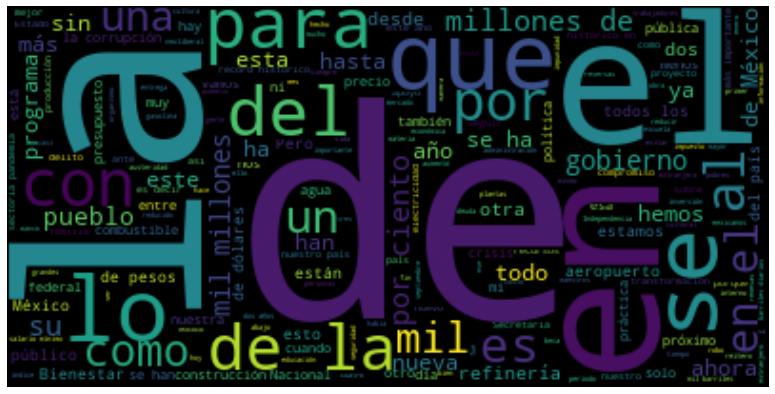

In [ ]:
texto = '\n'.join(df_informe.Parrafo.values)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Pues muy bonita pero muy inutil. El problema más grande de esta nube de palabras es que se hizo tomando en cuenta todas las palabras, y la mayoría de las que más se repiten no dan información.

Vamos entonces a usar la serie de palabras de paro que nos da `spacy` con el modelo en español que bajamos.

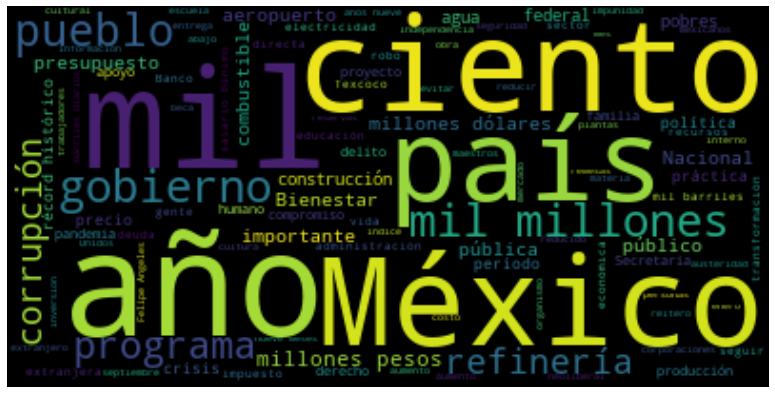

In [ ]:
palabras_paro = nlp.Defaults.stop_words

# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Y pues algo mejor, pero vemos que se siguen usando paabras que en otro contexto serían palabras significativas, pero que en un informa son muy esperables. Por ejemplo: México, o las que tengan que ver con porcentajes y con cantidades.

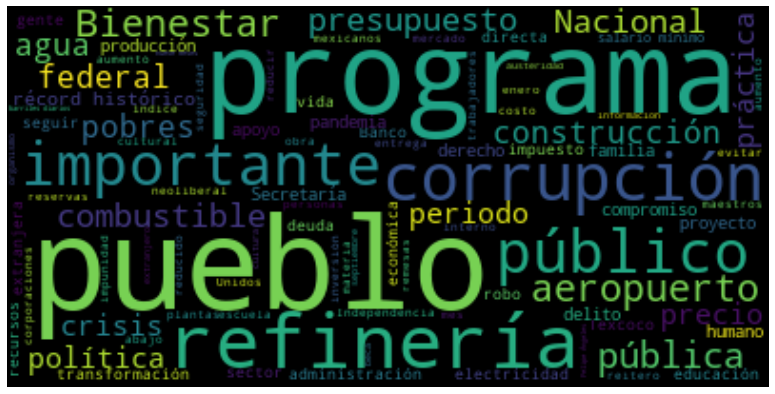

In [ ]:
# Actualizamos palabras a mano
palabras_paro.update([
  "México", "país", "gobierno",
  "año", "años", "mil", "millones", 
  "pesos", "dolares", "dólares", "ciento"
])

# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Un poco mejor, pero podemos ajustar mejor los tamaños de las letras y otros detalles

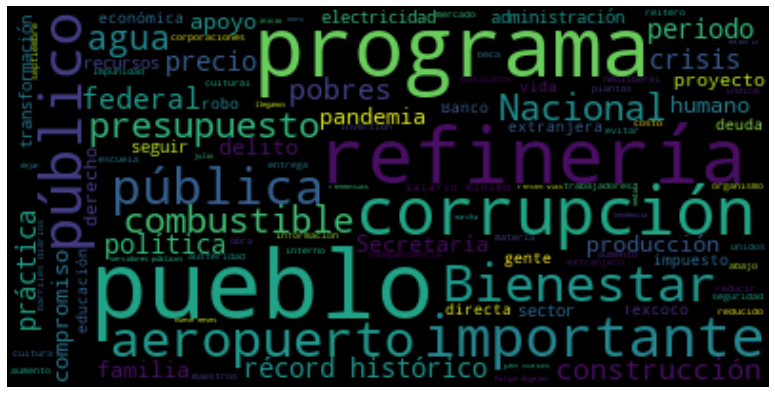

In [ ]:
# Una mascara redonda de radio dado en pixeles
radio = 200
largo = int(1.2 * radio)
x, y = np.ogrid[:2*largo, :2*largo]
mascara_redonda = (x - largo) ** 2 + (y - largo) ** 2 > radio ** 2
mascara_redonda = 255 * mascara_redonda.astype(int)


# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro,
    max_words=100,
    max_font_size=50,
    background_color="black",
    #mask= mask
).generate(texto)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Si te gusta lo puedes guardad
wc.to_file("nube.png")

## Usando `spacy`para extraer mejores características

Vamos ahora a utilizar spacy y su capacidad para tratar tokens de forma automñatica para extraer diferentes características importantes del informe y revisar como procesar texto con spacy.

Por ejemplo, vamos a ver que adjetivos utilizó el presidente en su discurso

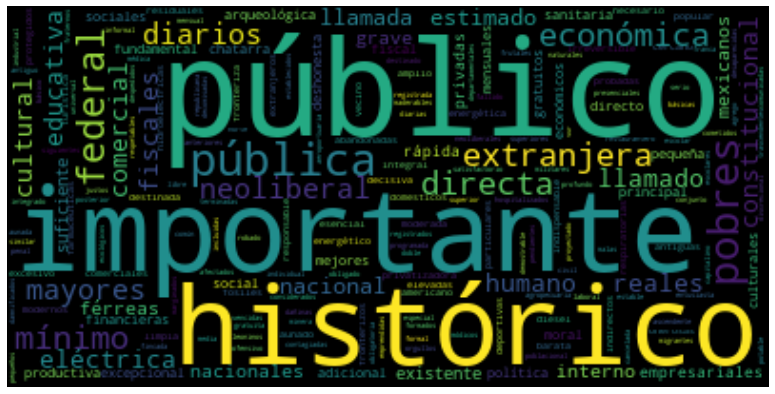

In [ ]:
doc = nlp(texto)

palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['ADJ']
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



¿Y que verbos utilizó el presidente? ¿Se puede sacar alguna conclusión? ¿Cambia si se usan los verbos en infinitivo?

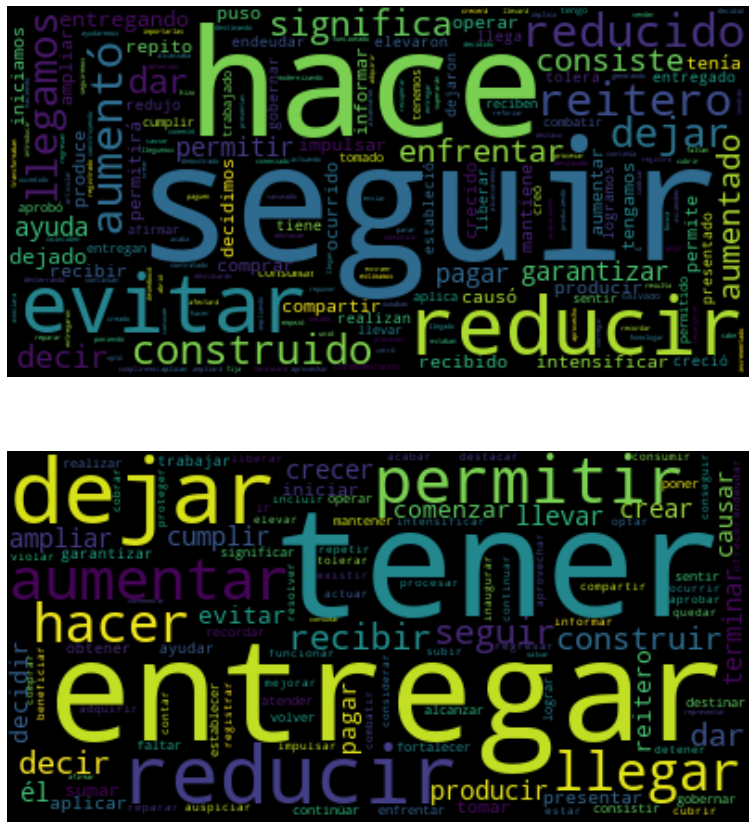

In [ ]:
verbos = ' '.join(
  [token.norm_ for token in doc if token.pos_ in ['VERB']]
)

verbos_inf = ' '.join(
  [token.lemma_ for token in doc if token.pos_ in ['VERB']]
)


# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(verbos)
wc2 = wordcloud.WordCloud().generate(verbos_inf)

# Muestra la nube de palabras
plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

¿Y su usamos puros sustantivos?

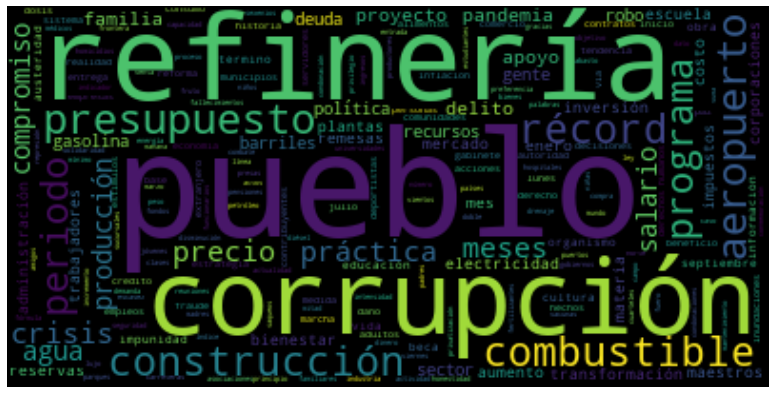

In [ ]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['NOUN']
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



¿Y por nombres propios?

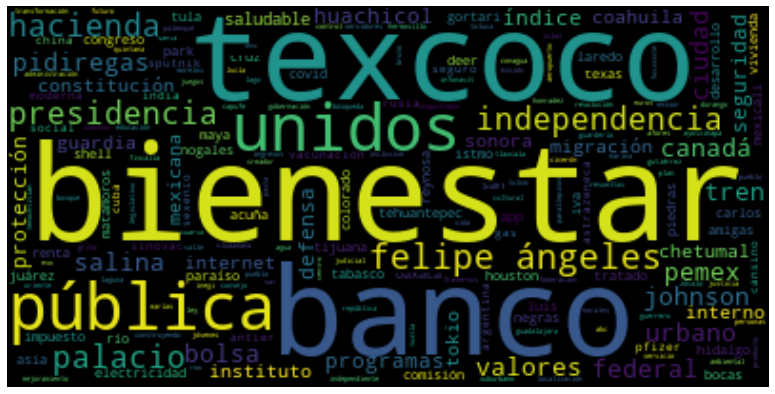

In [ ]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.pos_ in ['PROPN'] and
        token.norm_ not in ['méxico', 'nacional', 'secretaría', 'programa']
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


¿Y que tal si pudiermos ver los lugares que más mencionó?

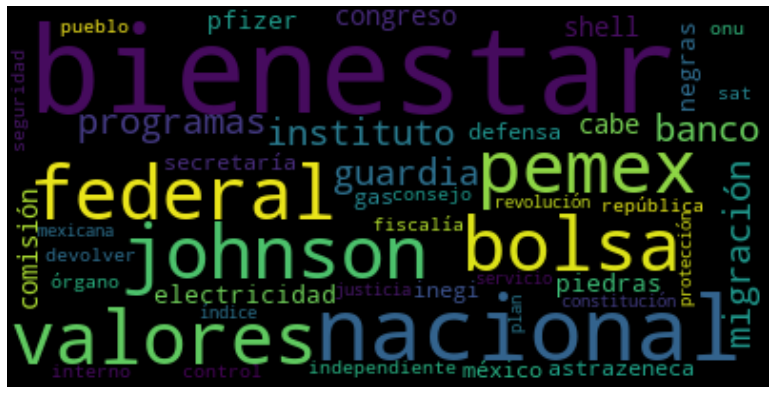

In [ ]:
palabras = ' '.join(
    [ 
     token.norm_ for token in doc
     if token.is_alpha and not token.like_num and not token.is_stop and
        not token.is_currency and token.ent_type_ is 'ORG' 
    ]
)

# Genera la nube de palabras
wc = wordcloud.WordCloud().generate(palabras)

# Muestra la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
